# Project : Automatic classification of skin lesions (melanoma detection)

### Karim Bekhti

## I - Database 

In [42]:
import numpy as np
import imageio as im
import matplotlib.pyplot as plt
import os, glob
import cv2
import skimage 

In [43]:
DB_pic = []
DB_seg = []
DB_sup = []
path = r"C:\Users\kbekh\Desktop\EMSE\Cours\GP Mathématiques\Traitement d'images - TB3\machine learning\project 2\.PROJECT_Data" 
os.chdir(path)
for file in glob.glob("*.jpg"):
    DB_pic += [im.imread(file)]

for file in glob.glob("*.png"):
    if file[15] == 'g' : #g de segmentation : on range dans DB_seg, sinon DB_sup
        DB_seg += [im.imread(file)]
    else : 
        DB_sup += [im.imread(file)]

C:\Users\kbekh\AppData\Local\Temp\ipykernel_20828\802894549.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  DB_pic += [im.imread(file)]
C:\Users\kbekh\AppData\Local\Temp\ipykernel_20828\802894549.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  DB_seg += [im.imread(file)]
C:\Users\kbekh\AppData\Local\Temp\ipykernel_20828\802894549.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` dir

For the set of properties used, we follow the steps indicated in :

[2] : K. Korotkov and R. Garcia. Computerized analysis of pigmented skin lesions: A review.
Artificial Intelligence in Medicine, 56(2):69 – 90, 2012
[7] : Tenenhaus A, Nkengne A, Horn JF, Serruys C, Giron A, Fertil B. Detection of melanoma from dermoscopic images of naevi acquired under uncontrolled conditions. Skin Res Technol. 2010 Feb;16(1):85-97. doi: 10.1111/j.1600-0846.2009.00385.x. PMID: 20384887. (use of the abcd rule)
Use of the ABCDE method : Asymetry, Border Irregularity, Color Variegation (non Uniformity of the color on the said mark), diameter.


The first three are usable :
 - Asymetry is computed on the segmented image : for that, we count the total number of pixels not superimposed with another pixel when the image is rotated 180° from its main axis 
 - The segmented image is also used to define both the perimeter and the area : it allows to determine the irregularity of the stain : we consider the stain as a circle and we compute R_circle/R_perimeter, with R_circle = sqrt(area * pi) and R_perimeter = perimeter/2 * pi 
 - For this part, we use the variance and mean of the values of colors of the original images, using a mask obtained through the segmented image
We then add intensity descriptors with mean and variance. 
For textural description we use the wavelet method that yielded the best result for texture classification in a previous work. 
    

## More on the Properties 

In [44]:
I = DB_seg[0]

Asymetry :

Using center :

Correct Result

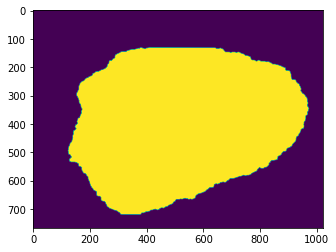

In [45]:
moments = cv2.moments(I)
orientation = 1/2*np.arctan2(2*moments['mu11'],moments['mu20']-moments['mu02']) 
center = (I.shape[1]//2, I.shape[0]//2) 
rotation_matrix = cv2.getRotationMatrix2D(center, orientation + 180, 1.0)
rotated_I = cv2.warpAffine(I, rotation_matrix, (I.shape[1], I.shape[0]))
plt.imshow(rotated_I)
plt.show()

Using centroid :

Result not usable

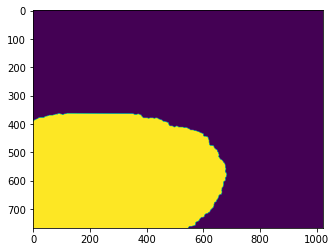

In [46]:
region = skimage.measure.label(I)
props = skimage.measure.regionprops(region)

moments = cv2.moments(I)
orientation = 1/2*np.arctan2(2*moments['mu11'],moments['mu20']-moments['mu02']) 
center = props[0].centroid
rotation_matrix = cv2.getRotationMatrix2D(center, orientation + 180, 1.0)
rotated_I = cv2.warpAffine(I, rotation_matrix, (I.shape[1], I.shape[0]))
plt.imshow(rotated_I)
plt.show()

Colors : 

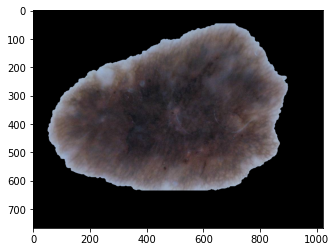

In [47]:
J = DB_pic[0]
np.max(I)
L = np.where(I==255)
Z = np.zeros(np.shape(J))
Z[L] = J[L]
plt.imshow(Z.astype(int))
I=DB_seg[0]

Textures : 

We have previously realized a work on texture descriptors and characterization in order to classify textures, and we found out the best method to do so was the granulometry method (the method used were : granulometry, wavelet transform, LBP and tamura's model; the methods are classified in order of precision).

The problem here is that the computational cost of the granular method implemented was far superior to the wavelet transform method, hence the use of wavelet transform here. 

[[85.75000000000003,
  83.75000000000001,
  11.750000000000004,
  75.56250000000003,
  39.562500000000014,
  37.812500000000014,
  4.812500000000002]]

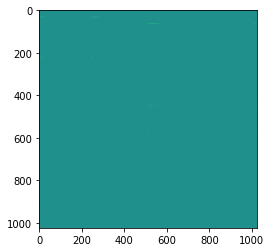

In [48]:
def Energy(I):
    return np.sum(I**2)

def make_image_square(image):
    new_image = np.copy(image)/np.max(image) #we will normalize the original image in order to keep the wavelet transform relevant
    #if we do not, the upper left part would be much more important than the rest in the later process of texture
    height, width = image.shape[:2]
    maxi = max(height, width)
    if maxi <4092 :
        max_dimension = 4092
    if maxi < 2048 :
        max_dimension = 2048
    if maxi <1024 : 
        max_dimension = 1024
    if maxi <512 :
        max_dimension = 512
    if  maxi <256 :
        max_dimension = 256
    #for consistency (size of the images are not fix in this database)
    square_image = np.zeros((max_dimension, max_dimension, *image.shape[2:]), dtype=image.dtype)
    x_position = (max_dimension - width)//2
    y_position = (max_dimension - height)//2
    square_image[y_position:y_position + height, x_position:x_position + width, ...] = new_image
    return square_image


def wavelet_transform(Images, wt = 'db1'):
    import pywt
    #Transform will take the modifies images, prop will take their properties
    Transform = []
    prop = []
    #For each image we transform using our wavelet
    for i in range(len(Images)):
        E = [] #will store the energy
        J, (J0, J1, J2) = pywt.dwt2(Images[i], wt)
        K, (K0, K1, K2) = pywt.dwt2(J, wt)

        #This part stack the matrix in order to reform an image
        K00 = np.column_stack((K/(np.max(K)+1),K0/(np.max(K0)+1)))
        K12= np.column_stack((K1/(np.max(K1)+1),K2/(np.max(K2)+1)))
        K_f = np.concatenate((K00,K12))
        J00 = np.column_stack((K_f,J0/(np.max(J0)+1)))
        J12 = np.column_stack((J1/(np.max(J1)+1),J2/(np.max(J2)+1)))
        J_f = np.concatenate((J00,J12))
        #+1 on the max to avoid dividing by 0

        #We calculate the energy of each part of the image [16]
        E = [Energy(J0),Energy(J1), Energy(J2), Energy(K), Energy(K0), Energy(K1), Energy(K2)]

        #Then we store the values 
        Transform.append(J_f)
        prop.append(E)
    return Transform, prop

J = DB_pic[2]
J_gray = cv2.cvtColor(J, cv2.COLOR_BGR2GRAY)
Transform, prop = wavelet_transform([make_image_square(J_gray)])
plt.imshow(Transform[0])
prop

## Implementation 

In [49]:
def properties(i): #i est le numéro de l'image 
    I=DB_seg[i]
    properties = []
    region = skimage.measure.label(I)
    props = skimage.measure.regionprops(region)
    area = props[0].area

    #Asymetry
    moments = cv2.moments(I)
    orientation = 1/2*np.arctan2(2*moments['mu11'],moments['mu20']-moments['mu02']) #to find the main orientation of the image

    center = (I.shape[1]//2, I.shape[0]//2) #center of rotation of the image (center of the image, weird result using props[0].centroid)
    rotation_matrix = cv2.getRotationMatrix2D(center, orientation + 180, 1.0)
    rotated_I = cv2.warpAffine(I, rotation_matrix, (I.shape[1], I.shape[0]))
    J = I - rotated_I
    J[J < 0]=1
    properties += [np.mean(J)*(I.shape[0]*I.shape[1])/(255*(area*2-1))]  #number of pixel that do not 
    #superimpose divided by the area of two stain (max asymetry, if only one pixel superimpose)
    #(divided by 255 because the pixels are set at 255 for the mean, not 1)

    #Irregularity
    perimeter = props[0].perimeter
    properties += [np.sqrt(area*np.pi)/(perimeter/(2*np.pi))]
    
    #Colors
    J = DB_pic[i]
    np.max(I)
    L = np.where(I==255)
    Z = np.zeros(np.shape(J))
    Z[L] = J[L]
    properties += [np.var(Z), np.mean(Z)]

    #Properties of the superpixel image
    K = DB_pic[i]
    properties += [np.var(K), np.mean(K)]

    #Textural properties of the original pic and the superpixel pic. 
    J = DB_pic[i]
    J_gray = cv2.cvtColor(J, cv2.COLOR_BGR2GRAY)
    Transform, energies = wavelet_transform([make_image_square(J_gray)])
    properties += energies[0]
    J = DB_sup[i]
    J_gray = cv2.cvtColor(J, cv2.COLOR_BGR2GRAY)
    Transform, energies = wavelet_transform([make_image_square(J_gray)])
    properties += energies[0]
    
    return properties
properties(1)

[0.1448074344042849,
 2.40830780951896,
 274.9653410195386,
 3.93339023023258,
 1024.8277719840278,
 164.6970567548696,
 214.75000000000009,
 58.750000000000014,
 12.750000000000005,
 124.68750000000004,
 102.18750000000004,
 27.937500000000014,
 5.937500000000002,
 125.25000000000003,
 121.25000000000004,
 52.250000000000014,
 6427.937500000003,
 182.18750000000009,
 162.93750000000009,
 39.18750000000002]

In [50]:
data = []
for i in range(len(DB_pic)):
    data +=[properties(i)]

In [51]:
array_data = np.array(data)
for i in range(array_data.shape[1]):
    array_data[:,i] = array_data[:,i]/np.max(array_data[:,i])
np.max(array_data)

1.0

## Learning of for the Data


First, from the paper quoted before, we apply the learning of four models (SVM, Neural Networks, Bayesian model and Logistic regression) to the dataset of properties for the images we have. 
Here we import Y for the first time : the problem that has risen from the given database, after thorough inspection, are that there was missing photos (our last picture is labeled 518, while 200 different pictures are in the database), and there were missing labels in the excel. 
With the use of condition, by getting the idea of each pictures, we managed to import Y properly, as shown below.

In [52]:
import pandas as pd

#Creation of X
X = array_data

#Creation of Y 
path = r"C:\Users\kbekh\Desktop\EMSE\Cours\GP Mathématiques\Traitement d'images - TB3\machine learning\project 2" 
df = pd.read_csv(path+ "\ISIC-2017_Data_GroundTruth_Classification.csv")
Truth = np.array(df["melanoma"])

#We load the indices of the images we have : 
path = r"C:\Users\kbekh\Desktop\EMSE\Cours\GP Mathématiques\Traitement d'images - TB3\machine learning\project 2\.PROJECT_Data" 
os.chdir(path)
indices = []
for file in glob.glob("*.jpg"):
    indices +=[file[9:12]]
Y=[]
for i in indices :
    condition = (df["image_id"] == "ISIC_0000" + i)
    Y += [(df[condition]["melanoma"])]
Y = np.array(Y).astype(int)[:,0]
Y


array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

Now, we can split our dataset in 4 parts : part for the learning (X train, Y train) and parts to test.
We add a random part (random state) and use 70% of the data set to train.

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
test_size = 0.3
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y , test_size=test_size, random_state=1111)

We define below the functions to produce the four different models.

In [54]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#Bayesian Classifier method

def train_bayesian_classifier(X_train, Y_train):
    classifier = GaussianNB()
    classifier.fit(X_train, Y_train)
    return classifier

#SVM Classifier method

def train_svm_classifier(X_train, Y_train):
    classifier = SVC(kernel="linear", C=1.0, probability=True)
    classifier.fit(X_train, Y_train)
    return classifier

#Neural Network

def train_nn_classifier(X_train, Y_train): #neural network
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy")
    model.fit(X_train, Y_train, epochs=100, verbose=False)
    return model

#Logistic regression

def train_logistic_regression(X_train, Y_train):
    X_train_split, X_test_split, Y_train_split, Y_test_split = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
    logistic_regression_model = LogisticRegression()
    logistic_regression_model.fit(X_train_split, Y_train_split)
    return logistic_regression_model


Then we apply the dataset to the different models.

In [55]:
bayesian_model = train_bayesian_classifier(X_train, Y_train)
SVM_model = train_svm_classifier(X_train, Y_train)
logistic_model = train_logistic_regression(X_train, Y_train)
neural_model = train_nn_classifier(X_train, Y_train)

In [56]:
bayesian_predict = bayesian_model.predict(X_test)
logistic_predict = logistic_model.predict(X_test)
SVM_predict = SVM_model.predict(X_test)
Neural_predict = np.round(neural_model.predict(X_test)).astype(int)[:,0]

2/2 [==============================] - 0s 7ms/step


And define a function to produce data to evaluate the models.
We use accuracy, F_score, recall, a ROC curve, and the AUC (area under the ROC curve), aswell as a confusion matrix.

In [57]:
def precision(Y_test, model):
      from sklearn.metrics import roc_curve, auc
      import matplotlib.pyplot as plt

      # Show confusion matrix
      Y_test = np.array([Y_test.astype(bool)])
      Y_hat = model.astype(bool)
      confm = confusion_matrix(Y_test.T, Y_hat.T)
      print(confm)
      disp = ConfusionMatrixDisplay(confusion_matrix=confm)
      disp.plot()

      #confusion matrix

      tp = confm[0,0]
      tn = confm[1,1]
      fn = confm[1,0]
      fp = confm[0,1]
      tot = tp + tn + fn + fp
      accuracy = (tp + tn )/ (tot)
      precision = tp/(tp+fp)
      recall = tp/(tp+fn)

      f_score = 2*((precision*recall)/(precision+recall))
      fpr, tpr, _= roc_curve(Y_test.astype(int).ravel(), (Y_hat > 0.5).astype(int).ravel())
      roc_auc = auc(fpr, tpr)

      plt.figure()
      plt.plot(fpr, tpr, lw=2, label='auc = {:.2f})'.format(roc_auc))
      plt.plot([0, 1], [0, 1], lw=2)
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('ROC Curve and AUC')
      plt.legend(loc='lower right')
      plt.show()
      return "accuracy :", accuracy, "recall", recall, "f_score", f_score

## Test 1 : 

properties : Asymetry, Border Irregularity, Color Variegation, Superpixels variation, Textural Information with Wavelet 

[[32  2]
 [17  9]]


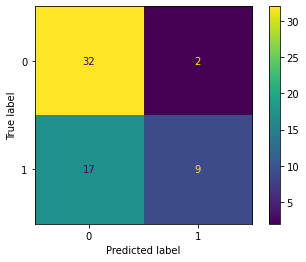

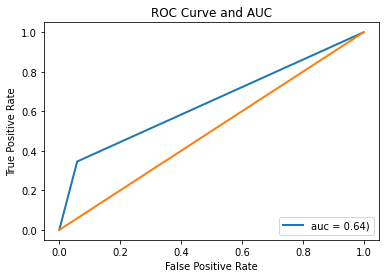

('accuracy :',
 0.6833333333333333,
 'recall',
 0.6530612244897959,
 'f_score',
 0.7710843373493975)

In [58]:
precision(Y_test, bayesian_predict)

[[26  8]
 [11 15]]


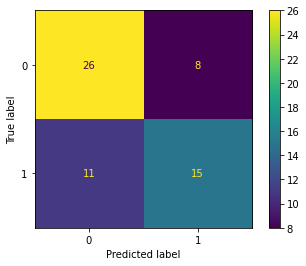

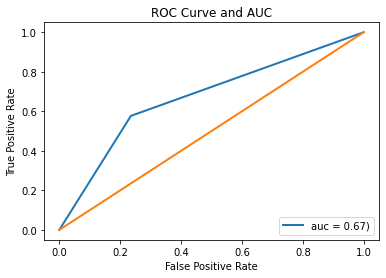

('accuracy :',
 0.6833333333333333,
 'recall',
 0.7027027027027027,
 'f_score',
 0.7323943661971832)

In [59]:
precision(Y_test, SVM_predict)

[[26  8]
 [10 16]]


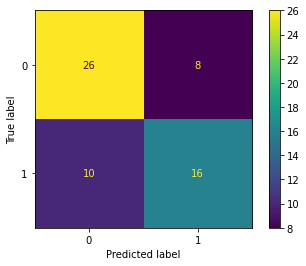

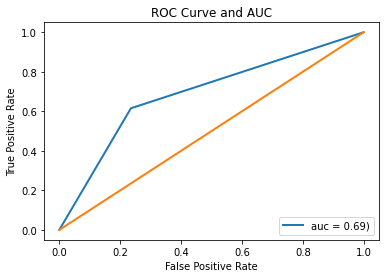

('accuracy :',
 0.7,
 'recall',
 0.7222222222222222,
 'f_score',
 0.7428571428571428)

In [60]:
precision(Y_test, logistic_predict)

[[28  6]
 [ 9 17]]


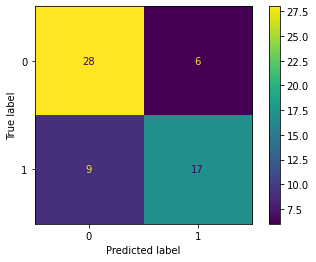

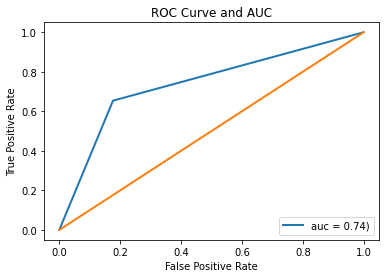

('accuracy :',
 0.75,
 'recall',
 0.7567567567567568,
 'f_score',
 0.7887323943661971)

In [61]:
precision(Y_test, Neural_predict)

Another test, changing the properties takn into account

## Test 2   

Asymetry, Border Irregularity, Color Variegation, Superpixels variation (whitout textural information) 

In [62]:
def properties_second(i): #i is the index of the image
    I=DB_seg[i]
    properties = []
    region = skimage.measure.label(I)
    props = skimage.measure.regionprops(region)
    area = props[0].area

    #Asymetry
    moments = cv2.moments(I)
    orientation = 1/2*np.arctan2(2*moments['mu11'],moments['mu20']-moments['mu02']) #to find the main orientation of the image

    center = (I.shape[1]//2, I.shape[0]//2) #center of rotation of the image (center of the image, weird result using props[0].centroid)
    rotation_matrix = cv2.getRotationMatrix2D(center, orientation + 180, 1.0)
    rotated_I = cv2.warpAffine(I, rotation_matrix, (I.shape[1], I.shape[0]))
    J = I - rotated_I
    J[J < 0]=1
    properties += [np.mean(J)*(I.shape[0]*I.shape[1])/(255*(area*2-1))]  #number of pixel that do not 
    #superimpose divided by the area of two stain (max asymetry, if only one pixel superimpose)
    #(divided by 255 because the pixels are set at 255 for the mean, not 1)

    #Irregularity
    perimeter = props[0].perimeter
    properties += [np.sqrt(area*np.pi)/(perimeter/(2*np.pi))]
    
    #Colors
    J = DB_pic[i]
    np.max(I)
    L = np.where(I==255)
    Z = np.zeros(np.shape(J))
    Z[L] = J[L]
    properties += [np.var(Z), np.mean(Z)]

    #Properties of the superpixel image
    K = DB_pic[i]
    properties += [np.var(K), np.mean(K)]    
    return properties

Here we took off the texture informations.

In [63]:
data = []
for i in range(len(DB_pic)):
    data +=[properties_second(i)]
test_size = 0.3
X = np.array(data)
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=test_size, random_state=1111)

bayesian_model = train_bayesian_classifier(X_train, Y_train)
SVM_model = train_svm_classifier(X_train, Y_train)
logistic_model = train_logistic_regression(X_train, Y_train)
neural_model = train_nn_classifier(X_train, Y_train)
Neural_predict = np.round(neural_model.predict(X_test)).astype(int)[:,0]

c:\Users\kbekh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2/2 [==============================] - 0s 2ms/step


[[30  4]
 [17  9]]


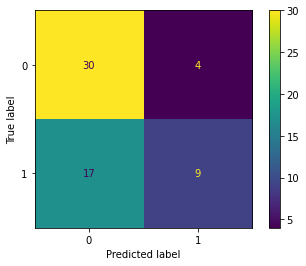

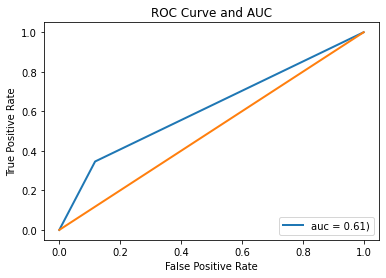

('accuracy :',
 0.65,
 'recall',
 0.6382978723404256,
 'f_score',
 0.7407407407407407)

In [64]:
precision(Y_test, Neural_predict)

## Test 3

Properties : Asymetry, Border Irregularity, Color Variegation, Superpixels variation, Textural Information with LBP 

In [65]:
def properties_third(i):
    from skimage import feature
    I=DB_seg[i]
    properties = []
    region = skimage.measure.label(I)
    props = skimage.measure.regionprops(region)
    area = props[0].area

    #Asymetry
    moments = cv2.moments(I)
    orientation = 1/2*np.arctan2(2*moments['mu11'],moments['mu20']-moments['mu02']) #to find the main orientation of the image

    center = (I.shape[1]//2, I.shape[0]//2) #center of rotation of the image (center of the image, weird result using props[0].centroid)
    rotation_matrix = cv2.getRotationMatrix2D(center, orientation + 180, 1.0)
    rotated_I = cv2.warpAffine(I, rotation_matrix, (I.shape[1], I.shape[0]))
    J = I - rotated_I
    J[J < 0]=1
    properties += [np.mean(J)*(I.shape[0]*I.shape[1])/(255*(area*2-1))]  #number of pixel that do not 
    #superimpose divided by the area of two stain (max asymetry, if only one pixel superimpose)
    #(divided by 255 because the pixels are set at 255 for the mean, not 1)

    #Irregularity
    perimeter = props[0].perimeter
    properties += [(4*area*np.pi)/(perimeter**2)] #changed 
    
    #Colors
    J = DB_pic[i]
    np.max(I)
    L = np.where(I==255)
    Z = np.zeros(np.shape(J))
    Z[L] = J[L]
    properties += [np.var(Z), np.mean(Z)]

    #Properties of the superpixel image
    K = DB_pic[i]
    properties += [np.var(K), np.mean(K)]    

    #Textural descriptor ##This method is a courtesy of Gaetan Allaire
    J_gray =cv2.cvtColor(J, cv2.COLOR_BGR2GRAY)
    K_gray =cv2.cvtColor(K, cv2.COLOR_BGR2GRAY)
    # Extract texture features using Local Binary Patterns (LBP) on superpixel image
    lbp_superpixel = feature.local_binary_pattern(K_gray, P=8, R=1, method="uniform")
    hist_lbp_superpixel, _ = np.histogram(lbp_superpixel.ravel(), bins=np.arange(0, 10), range=(0, 9))
    lbp_superpixel = feature.local_binary_pattern(J_gray, P=8, R=1, method="uniform")
    hist_lbp_picture, _ = np.histogram(lbp_superpixel.ravel(), bins=np.arange(0, 10), range=(0, 9))
    properties += list(hist_lbp_superpixel)
    properties += list(hist_lbp_picture)    
    return properties

2/2 [==============================] - 0s 6ms/step
[[26  8]
 [ 9 17]]


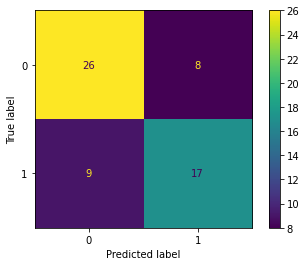

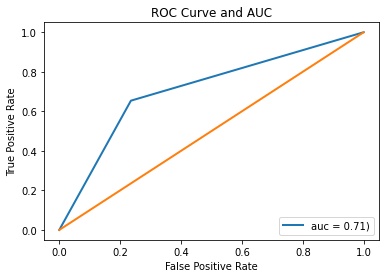

('accuracy :',
 0.7166666666666667,
 'recall',
 0.7428571428571429,
 'f_score',
 0.7536231884057971)

In [66]:
data = []
for i in range(len(DB_pic)):
    data +=[properties_third(i)]
array_data = np.array(data)
for i in range(array_data.shape[1]):
    array_data[:,i] = array_data[:,i]/np.max(array_data[:,i])
np.max(array_data)
test_size = 0.3
X = array_data
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=test_size, random_state=1111)

bayesian_model = train_bayesian_classifier(X_train, Y_train)
SVM_model = train_svm_classifier(X_train, Y_train)
logistic_model = train_logistic_regression(X_train, Y_train)
neural_model = train_nn_classifier(X_train, Y_train)
Neural_predict = np.round(neural_model.predict(X_test)).astype(int)[:,0]
precision(Y_test, Neural_predict)

## Test 4 : More shape descriptors

Asymetry, Border Irregularity, Color Variegation, Superpixels variation, Textural Information with Wavelet + various shape descriptors

In [67]:
def properties_fourth(i): #i est le numéro de l'image 
    I=DB_seg[i]
    properties = []
    region = skimage.measure.label(I)
    props = skimage.measure.regionprops(region)
    area = props[0].area

    #Asymetry
    moments = cv2.moments(I)
    orientation = 1/2*np.arctan2(2*moments['mu11'],moments['mu20']-moments['mu02']) #to find the main orientation of the image

    center = (I.shape[1]//2, I.shape[0]//2) #center of rotation of the image (center of the image, weird result using props[0].centroid)
    rotation_matrix = cv2.getRotationMatrix2D(center, orientation + 180, 1.0)
    rotated_I = cv2.warpAffine(I, rotation_matrix, (I.shape[1], I.shape[0]))
    J = I - rotated_I
    J[J < 0]=1
    properties += [np.mean(J)*(I.shape[0]*I.shape[1])/(255*(area*2-1))]  #number of pixel that do not 
    #superimpose divided by the area of two stain (max asymetry, if only one pixel superimpose)
    #(divided by 255 because the pixels are set at 255 for the mean, not 1)

    #Irregularity
    perimeter = props[0].perimeter
    properties += [np.sqrt(area*np.pi)/(perimeter/(2*np.pi))]
    
    #Colors
    J = DB_pic[i]
    np.max(I)
    L = np.where(I==255)
    Z = np.zeros(np.shape(J))
    Z[L] = J[L]
    properties += [np.var(Z), np.mean(Z)]

    #Properties of the superpixel image
    K = DB_pic[i]
    properties += [np.var(K), np.mean(K)]

    #Textural properties of the original pic and the superpixel pic. 
    J = DB_pic[i]
    J_gray = cv2.cvtColor(J, cv2.COLOR_BGR2GRAY)
    Transform, energies = wavelet_transform([make_image_square(J_gray)])
    properties += energies[0]
    J = DB_sup[i]
    J_gray = cv2.cvtColor(J, cv2.COLOR_BGR2GRAY)
    Transform, energies = wavelet_transform([make_image_square(J_gray)])
    properties += energies[0]
    properties+=props[0].eccentricity
    properties+=props[0].perimeter
    properties+=props[0].extent
    properties+=props[0].axis_minor_length
    properties+=props[0].axis_major_length
    properties+=props[0].equivalent_diameter_area
    properties+=props[0].solidity
    return properties
properties(1)    


[0.1448074344042849,
 2.40830780951896,
 274.9653410195386,
 3.93339023023258,
 1024.8277719840278,
 164.6970567548696,
 214.75000000000009,
 58.750000000000014,
 12.750000000000005,
 124.68750000000004,
 102.18750000000004,
 27.937500000000014,
 5.937500000000002,
 125.25000000000003,
 121.25000000000004,
 52.250000000000014,
 6427.937500000003,
 182.18750000000009,
 162.93750000000009,
 39.18750000000002]

2/2 [==============================] - 0s 6ms/step
[[26  8]
 [ 9 17]]


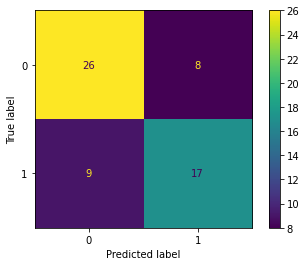

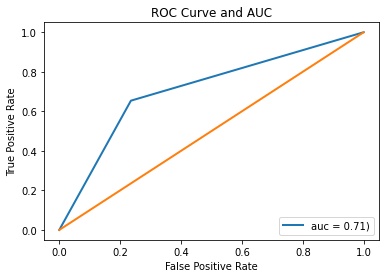

('accuracy :',
 0.7166666666666667,
 'recall',
 0.7428571428571429,
 'f_score',
 0.7536231884057971)

In [68]:
data = []
for i in range(len(DB_pic)):
    data +=[properties_third(i)]
array_data = np.array(data)
for i in range(array_data.shape[1]):
    array_data[:,i] = array_data[:,i]/np.max(array_data[:,i])
np.max(array_data)
test_size = 0.3
X = array_data
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=test_size, random_state=1111)

bayesian_model = train_bayesian_classifier(X_train, Y_train)
SVM_model = train_svm_classifier(X_train, Y_train)
logistic_model = train_logistic_regression(X_train, Y_train)
neural_model = train_nn_classifier(X_train, Y_train)
Neural_predict = np.round(neural_model.predict(X_test)).astype(int)[:,0]
precision(Y_test, Neural_predict)

## Conclusion

For the Neural network model, the matrix to compare results :

In [69]:
L = np.array([["Accuracy",0.7,0.62,0.7,0.75], ["Recall",0.74,0.64,0.72,0.77], ["Fscore",0.74,0.68,0.74,0.78]])
dfL = pd.DataFrame(L, columns=["Metric", "Test 1", "Test 2", "Test 3", "Test 4"])
dfL

,Metric,Test 1,Test 2,Test 3,Test 4
0,Accuracy,0.7,0.62,0.7,0.75
1,Recall,0.74,0.64,0.72,0.77
2,Fscore,0.74,0.68,0.74,0.78


The test 4 with shapes descriptors, wavelet transform, and ABC method yield the best results, which is confirmed by the area under the ROC curve of the test 4, auc = 0.74 

[[26  8]
 [ 9 17]]


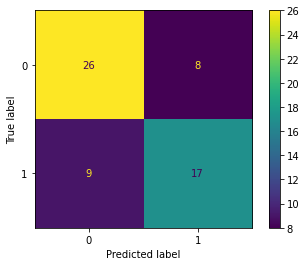

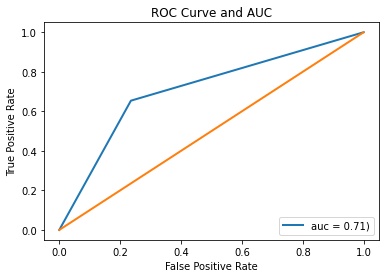

('accuracy :',
 0.7166666666666667,
 'recall',
 0.7428571428571429,
 'f_score',
 0.7536231884057971)

In [70]:
precision(Y_test, Neural_predict)

[[32  2]
 [17  9]]


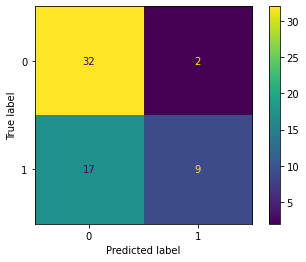

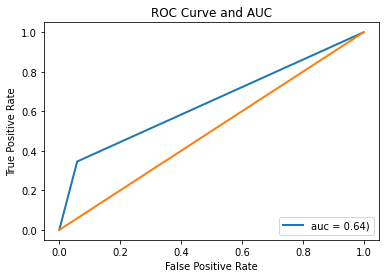

('accuracy :',
 0.6833333333333333,
 'recall',
 0.6530612244897959,
 'f_score',
 0.7710843373493975)

In [71]:
precision(Y_test, bayesian_predict)

[[26  8]
 [11 15]]


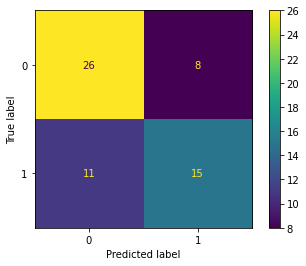

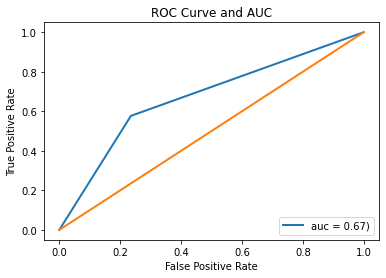

('accuracy :',
 0.6833333333333333,
 'recall',
 0.7027027027027027,
 'f_score',
 0.7323943661971832)

In [72]:
precision(Y_test, SVM_predict)

[[26  8]
 [10 16]]


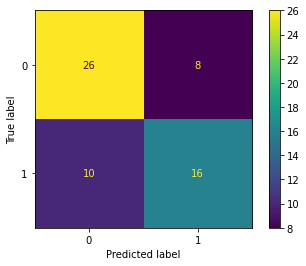

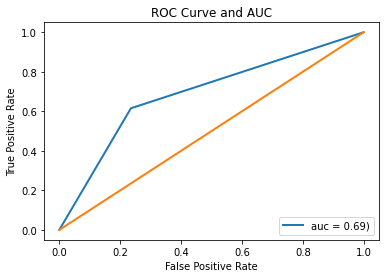

('accuracy :',
 0.7,
 'recall',
 0.7222222222222222,
 'f_score',
 0.7428571428571428)

In [73]:
precision(Y_test, logistic_predict)

In [74]:
L = np.array([["Accuracy",0.75,0.7,0.68,0.68], ["Recall",0.77,0.66,0.71,0.71], ["Fscore",0.78,0.79,0.72,0.72], ["AUC",0.74,0.66,0.68,0.68]])
dfL = pd.DataFrame(L, columns=["Metric", "Neural Network", "SVM" , "Bayesian Model", "Logistic Regression"])
dfL


,Metric,Neural Network,SVM,Bayesian Model,Logistic Regression
0,Accuracy,0.75,0.7,0.68,0.68
1,Recall,0.77,0.66,0.71,0.71
2,Fscore,0.78,0.79,0.72,0.72
3,AUC,0.74,0.66,0.68,0.68


Neural Network is the best model to predict the nature of the stain. 